In [1]:
import uproot
from physlite_experiments.deserialization_hacks import tree_arrays
import awkward as ak
import numpy as np
import time
import os
import h5py
from functools import partial
import timeit

In [2]:
def filter_branch(branch):
        k = branch.name

        if not "Aux" in k:
            return False

        # the following don't contain data (in split files)
        if k.endswith("."):
            return False
        if "SG::" in k:
            return False
        if k.endswith("Base"):
            return False

        # are often empty
        # see https://github.com/scikit-hep/uproot4/issues/126
        # -> now fixed, but my custom deserialization does not work yet with them
        if "DescrTags" in k:
            return False
        
        return True

In [3]:
def regroup(array_dict):
    regrouped = {}
    for k_top in set(k.split(".")[0] for k in array_dict):
        if k_top == "EventInfoAux":
            # skip that for now - let's use EventInfoAuxDyn
            continue
        if k_top == "EventInfoAuxDyn":
            k_top = "EventInfoAux"
        # zip will put together jagged arrays with common offsets
        def ak_zip(depth_limit=2):
            return ak.zip(
                {k.replace(k_top, "")[1:] : array_dict[k] for k in array_dict if k_top in k},
                depth_limit=depth_limit
            )
        # for some containers this will work 2 levels, for some only up to 1
        try:
            v = ak_zip(depth_limit=2)
        except ValueError:
            v = ak_zip(depth_limit=1)
        regrouped[k_top.replace("AuxDyn", "").replace("Aux", "")] = v
    # lets restructure such that we get TrigMatchedObjets.<trigger-name>
    # instead of AnalysisHLT_<trigger_name>.TrigMatchedObjects
    trig_matched_objects = ak.zip(
        {
            k.replace("AnalysisHLT_", "") : regrouped[k].TrigMatchedObjects
            for k in regrouped if "AnalysisHLT" in k
        },
        depth_limit=1
    )
    for k in list(regrouped.keys()):
        if "AnalysisHLT" in k:
            regrouped.pop(k)
    regrouped["TrigMatchedObjects"] = trig_matched_objects
    return ak.zip(regrouped, depth_limit=1)

In [4]:
rootfile = "user.nihartma.22884623.EXT0._000001.DAOD_PHYSLITE.test.pool.root"
rootfile_large_baskets = "/home/nikolai/code/AODCompressedFileCreation/run/DAOD_PHYSLITE.zlib_lvl5_basket1073741824_flush10000_split99__AOD.14795494._005958/DAOD_PHYSLITE.DAOD_PHYSLITE.zlib_lvl5_basket1073741824_flush10000_split99__AOD.14795494._005958.pool.root"

In [5]:
%%time
# file from user.nihartma.physlite_test_ttbar_split99.001_EXT0
f = uproot.open(rootfile)
tree = f["CollectionTree"]
array_dict = tree_arrays(tree, filter_branch=filter_branch)

CPU times: user 6.35 s, sys: 193 ms, total: 6.54 s
Wall time: 6.57 s


In [6]:
events = ak.zip(array_dict, depth_limit=1)

In [7]:
events_regrouped = regroup(array_dict)

In [8]:
ak.to_parquet(events, "events_benchmark.parquet")

In [9]:
ak.to_parquet(events_regrouped, "events_benchmark_regrouped.parquet")

In [10]:
def write_hdf(filename, events, compression="lzf"):
    form, length, container = ak.to_buffers(events)
    with h5py.File(filename, "w") as file:
        group = file.create_group("awkward")
        for k in container:
            v = container[k]
            group.create_dataset(k, shape=v.shape, dtype=v.dtype, data=v, compression=compression)
        group.attrs["form"] = form.tojson()
        group.attrs["length"] = length

In [11]:
write_hdf("events_benchmark_lzf.h5", events, compression="lzf")

In [12]:
write_hdf("events_benchmark_lzf_regrouped.h5", events_regrouped, compression="lzf")

In [13]:
write_hdf("events_benchmark_gzip.h5", events, compression="gzip")

In [14]:
write_hdf("events_benchmark_gzip_regrouped.h5", events_regrouped, compression="gzip")

In [15]:
def write_npz(filename, events):
    form, length, container = ak.to_buffers(events)
    npz_container = dict(container, form=np.array(form.tojson()), length=np.array(length))
    np.savez_compressed(filename, **npz_container)

In [16]:
write_npz("events_benchmark.npz", events)

In [17]:
write_npz("events_benchmark_regrouped.npz", events_regrouped)

In [18]:
def benchmark_root(rootfile):
    f = uproot.open(rootfile)
    tree = f["CollectionTree"]
    array_dict = tree_arrays(tree, filter_branch=filter_branch)

In [19]:
def benchmark_parquet(filename):
    return ak.from_parquet(filename)

In [20]:
def benchmark_hdf(filename):
    with h5py.File(filename, "r") as file:
        group = file["awkward"]
        reconstituted = ak.from_buffers(
            ak.forms.Form.fromjson(group.attrs["form"]),
            group.attrs["length"],
            {k: np.asarray(v) for k, v in group.items()},
        )

In [21]:
def benchmark_npz(filename):
    with np.load(filename) as npf:
        container = dict(npf.items())
        form = ak.forms.Form.fromjson(str(container.pop("form")))
        length = int(container.pop("length"))
        return ak.from_buffers(
            form,
            length,
            container
        )

In [37]:
timings = {}
for label, f_benchmark, filename in [
    ("root", benchmark_root, rootfile),
    ("root_largebasket", benchmark_root, rootfile_large_baskets),
    ("npz", benchmark_npz, "events_benchmark.npz"),
    ("npz_dedup", benchmark_npz, "events_benchmark_regrouped.npz"),
    ("hdf_lzf", benchmark_hdf, "events_benchmark_lzf.h5"),
    ("hdf_lzf_dedup", benchmark_hdf, "events_benchmark_lzf_regrouped.h5"),
    ("hdf_gzip", benchmark_hdf, "events_benchmark_gzip.h5"),
    ("hdf_gzip_dedup", benchmark_hdf, "events_benchmark_gzip_regrouped.h5"),
    ("parquet", benchmark_parquet, "events_benchmark.parquet"),
    ("parquet_dedup", benchmark_parquet, "events_benchmark_regrouped.parquet"),
]:
    print("Running benchmark for", label)
    timings[label] = timeit.Timer(partial(f_benchmark, filename)).repeat(number=1, repeat=5)

Running benchmark for root
Running benchmark for root_largebasket
Running benchmark for npz
Running benchmark for npz_dedup
Running benchmark for hdf_lzf
Running benchmark for hdf_lzf_dedup
Running benchmark for hdf_gzip
Running benchmark for hdf_gzip_dedup
Running benchmark for parquet
Running benchmark for parquet_dedup


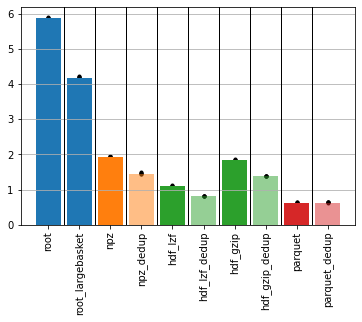

In [116]:
colors = {
    "root" : "C0",
    "npz" : "C1",
    "hdf" : "C2",
    "parquet" : "C3"
}
for k, vs in timings.items():
    if "dedup" in k:
        alpha=0.5
    else:
        alpha = 1
    desc = k
    plt.bar([desc], [min(vs)], color=colors[k.split("_")[0]], alpha=alpha)
    plt.scatter([desc] * len(vs), vs, marker=".", color="black")
plt.xticks(rotation=90);
for x in np.arange(0.5, len(timings) - 1, 1):
    plt.axvline(x, color="black", linewidth=1)
plt.grid(axis="y")